#### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

2023-04-20 10:13:50.593600: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 10:13:50.640123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 10:13:51.347322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Make keras use gpu (und evtl auch alle Kerne xD)

In [2]:
from keras import backend as K
config = tf.compat.v1.ConfigProto(device_count = {'GPU': len(tf.config.list_physical_devices('GPU')), # sollte 1 sein, weil wir nur eine GPU haben
                                                  'CPU': mp.cpu_count()})                             # sollte 64 sein, weil wir 64 CPU Kerne haben
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2023-04-20 10:13:53.010797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77802 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


#### Helper Functions

In [3]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation loss')
    # make the plot look nice
    fig.legend()
    fig.show()

#### Load Datasets

In [4]:
original_dataset_dir = 'data/train'

base_dir = 'data/cats_and_dogs_2k/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

#### Global Variables

In [5]:
EPOCHS = 30
STEPS_PER_EPOCH = 100
VAL_STEPS = 50
TARGET_SIZE = (150, 150)
BATCH_SIZE = 20

#### Baseline Model

In [6]:
def base_model():
    model = tf.keras.models.Sequential()
    # CNN Block 1
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150,150,3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Classification Block
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation= 'relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model
baseline_model = base_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

2023-04-20 10:13:53.240920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77802 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


##### Compile

In [7]:
baseline_model.compile(loss = 'binary_crossentropy',
                       optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                       metrics=['acc'])

##### Prepare Data

In [8]:
# NO DATA AUGMENTATION
datagen = test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = datagen.flow_from_directory(validation_dir,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Fit

In [9]:
baseline_history = baseline_model.fit(
    train_gen,
    steps_per_epoch= STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data=val_gen,
    validation_steps=VAL_STEPS
)

Epoch 1/30


2023-04-20 10:13:54.774391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 10:13:56.567626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-20 10:13:57.420753: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-20 10:13:57.537781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-20 10:13:58.085465: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fdf3009a510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-20 10:13:58.085497: I tensorflo

 99/100 [============================>.] - ETA: 0s - loss: 0.6897 - acc: 0.5434

2023-04-20 10:14:02.936648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 10s 51ms/step - loss: 0.6903 - acc: 0.5420 - val_loss: 0.6677 - val_acc: 0.5960
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6523 - acc: 0.6135 - val_loss: 0.6339 - val_acc: 0.6380
Epoch 3/30
100/100 [==============================] - 5s 48ms/step - loss: 0.6095 - acc: 0.6640 - val_loss: 0.6642 - val_acc: 0.6010
Epoch 4/30
100/100 [==============================] - 5s 53ms/step - loss: 0.5622 - acc: 0.7185 - val_loss: 0.6028 - val_acc: 0.6700
Epoch 5/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5329 - acc: 0.7380 - val_loss: 0.5812 - val_acc: 0.6990
Epoch 6/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5016 - acc: 0.7495 - val_loss: 0.5799 - val_acc: 0.6810
Epoch 7/30
100/100 [==============================] - 5s 50ms/step - loss: 0.4793 - acc: 0.7730 - val_loss: 0.5770 - val_acc: 0.7150
Epoch 8/30
100/100 [==============================] - 5s 49ms/step - loss: 0.45

##### Plot Results

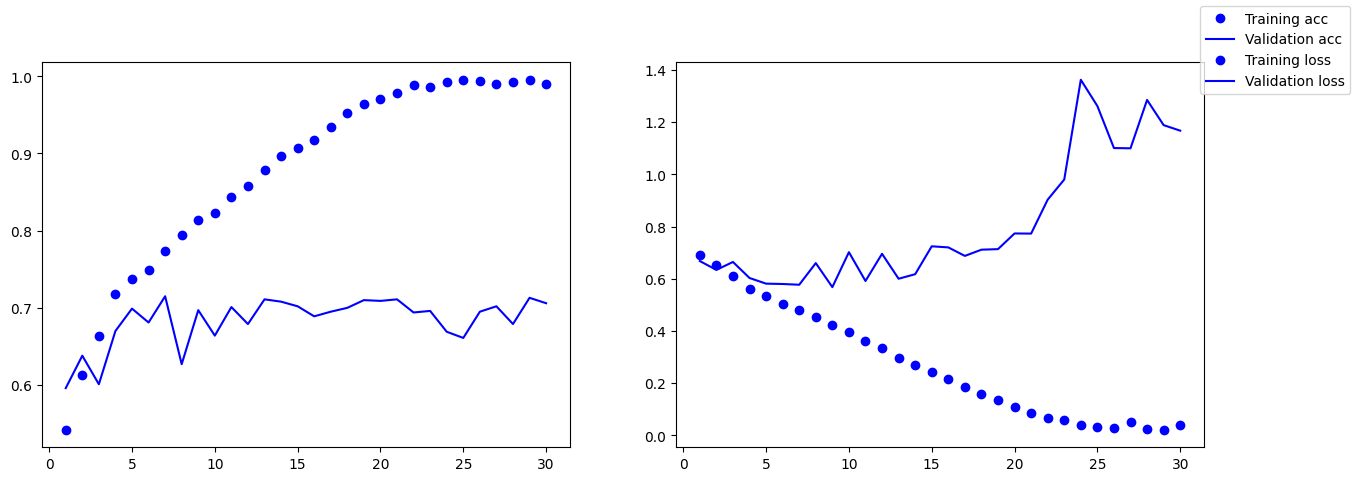

In [10]:
plot_history(baseline_history)